In [1]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [2]:
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
min_len = 200
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 111
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below the threshold: 200
found a seq of length: 111 but below

### Load joblib file

In [6]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#            "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/513_aas_seq_and_angles.joblib")
info = joblib.load("experiments/513_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [7]:
from massive_pnerf import *

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [9]:
# featurize
scaffolds = build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [14]:
%%timeit
# convert coords - fold
coords, mask = proto_fold(seq[:-padding_seq], **scaffolds)
coords_flat  = rearrange(coords, 'l c d -> (l c) d') 

31.8 ms ± 628 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Profiling

In [13]:
# %load_ext snakeviz
# %snakeviz proto_fold(seq[:-padding_seq], **scaffolds)

#### Display

In [11]:
true_coords.shape, len(int_seq[:-padding_angles-1]), seq

(torch.Size([7182, 3]),
 506,
 'KTLVYCSEGSPEGFNPQLFISGTTYDASSVPLYNRLVEFKIGTTEVIPGLAEKWEVSEDGKTYTFHLRKGVKWHDNKEFKPTRELNADDVVFSFDRQKNAQNPYHKVSGGSYEYFEGMGLPELISEVKKVDDNTVQFVLTRPEAPFLADLAMDFASILSKEYADAMMKAGTPEKLDLNPIGTGPFQLQQYQKDSRIRYKAFDGYWGTKPQIDTLVFSITPDASVRYAKLQKNECQVMPYPNPADIARMKQDKSINLMEMPGLNVGYLSYNVQKKPLDDVKVRQALTYAVNKDAIIKAVYQGAGVSAKNLIPPTMWGYNDDVQDYTYDPEKAKALLKEAGLEKGFSIDLWAMPVQRPYNPNARRMAEMIQADWAKVGVQAKIVTYEWGEYLKRAKDGEHQTVMMGWTGDNGDPDNFFATEFSCAASEQGSNYSKWCYKPFEDLIQPARATDDHNKRVELYKQAQVVMHDQAPALIIAHSTVFEPVRKEVKGYVVDPLGKHHFENVSIE______')

In [12]:
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_flat) 
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
sb = sidechainnet.StructureBuilder(int_seq[:-padding_angles], crd=true_coords[:-14*padding_angles]) # coords_flat
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Diagnose rotation matrix

In [14]:
# Standard import
import matplotlib.pyplot as plt
# Import 3D Axes 
from mpl_toolkits.mplot3d import axes3d

In [22]:
%matplotlib notebook

#### True backbone

<IPython.core.display.Javascript object>


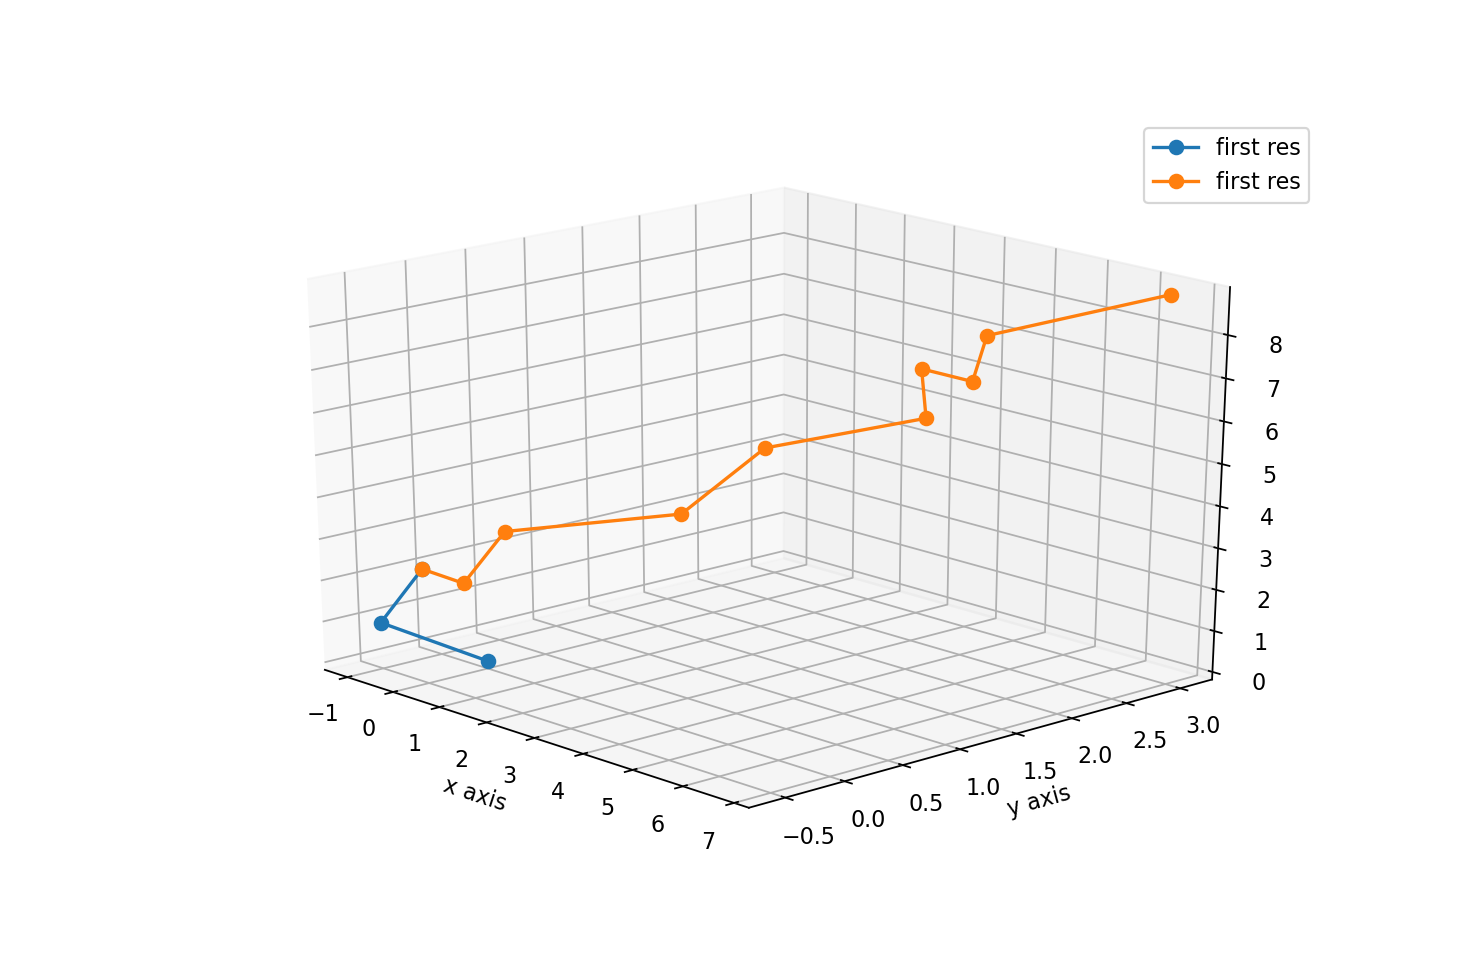

In [23]:
# print init of true chain to compare
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
start_res = (torch.cat([true_coords[:3, :],
                        true_coords[14:14+3],
                        true_coords[28:28+3],
                        true_coords[42:42+3]], dim=0) - true_coords[0, :]).numpy()

ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="first res")
ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="first res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")
# ax.plot(destin_first[:, 0], destin_first[:, 1], destin_first[:, 2],  "g-o", label="rotated second aa")
plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### True and predicted backbone

<IPython.core.display.Javascript object>


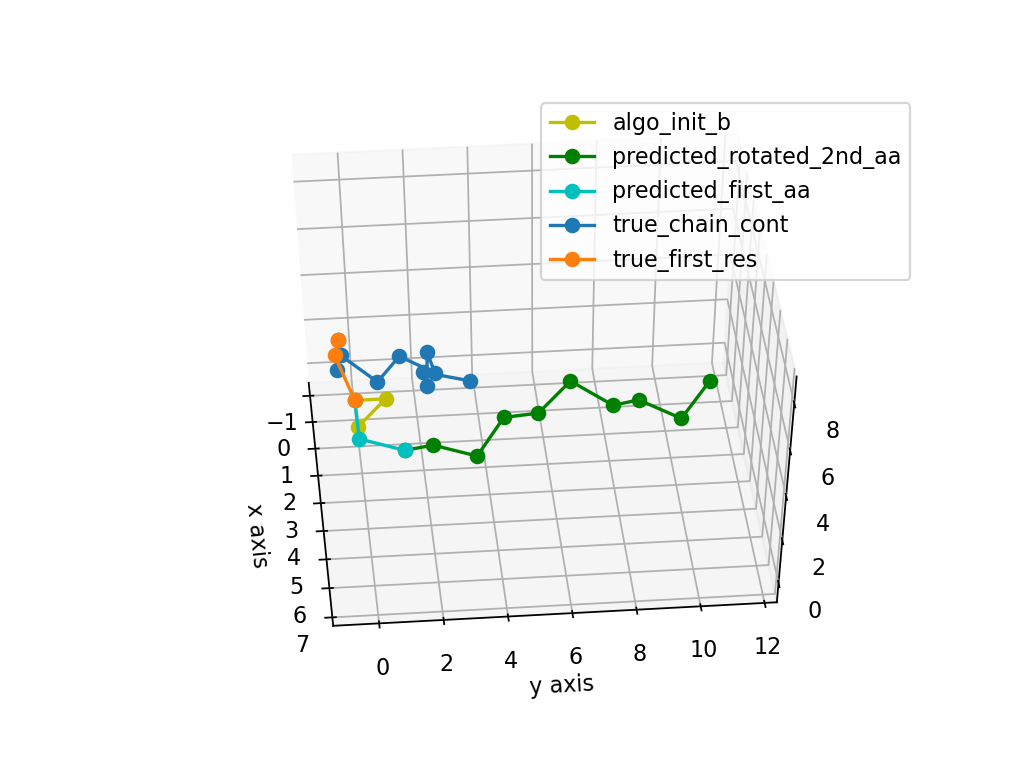

In [24]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
prev_res = coords[0, :3].numpy()
destin_first = rearrange(coords[:4, :3], 'l c d -> (l c) d').numpy()


ax.plot([1,0,0],[0,1,0],[0,0,0], 'y-o', label="algo_init_b")
ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(prev_res[:, 0], prev_res[:, 1], prev_res[:, 2],  "c-o", label="predicted_first_aa")

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### Rotate and show superimposed to confirm

In [25]:
def kabsch_torch(X, Y):
    """ Kabsch alignment of X into Y. 
        Assumes X,Y are both (Dims x N_points). See below for wrapper.
    """
    #  center X and Y to the origin
    X_ = X - X.mean(dim=-1, keepdim=True)
    Y_ = Y - Y.mean(dim=-1, keepdim=True)
    # calculate convariance matrix (for each prot in the batch)
    C = torch.matmul(X_, Y_.t())
    # Optimal rotation matrix via SVD - warning! W must be transposed
    V, S, W = torch.svd(C.detach())
    # determinant sign for direction correction
    d = (torch.det(V) * torch.det(W)) < 0.0
    if d:
        S[-1]    = S[-1] * (-1)
        V[:, -1] = V[:, -1] * (-1)
    # Create Rotation matrix U
    U = torch.matmul(V, W.t())
    # calculate rotations
    X_ = torch.matmul(X_.t(), U).t()
    # return centered and aligned
    return X_, Y_


In [26]:
flat_mask = rearrange(scaffolds["cloud_mask"], 'l d -> (l d)')
coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                              true_coords[:-14*padding_angles][flat_mask].t())
# create coord scaffolds
scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
# fill
scaff_coords_aligned[flat_mask] = coords_aligned.t()
scaff_labels_aligned[flat_mask] = labels_aligned.t()
# replace vars
coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned

<IPython.core.display.Javascript object>


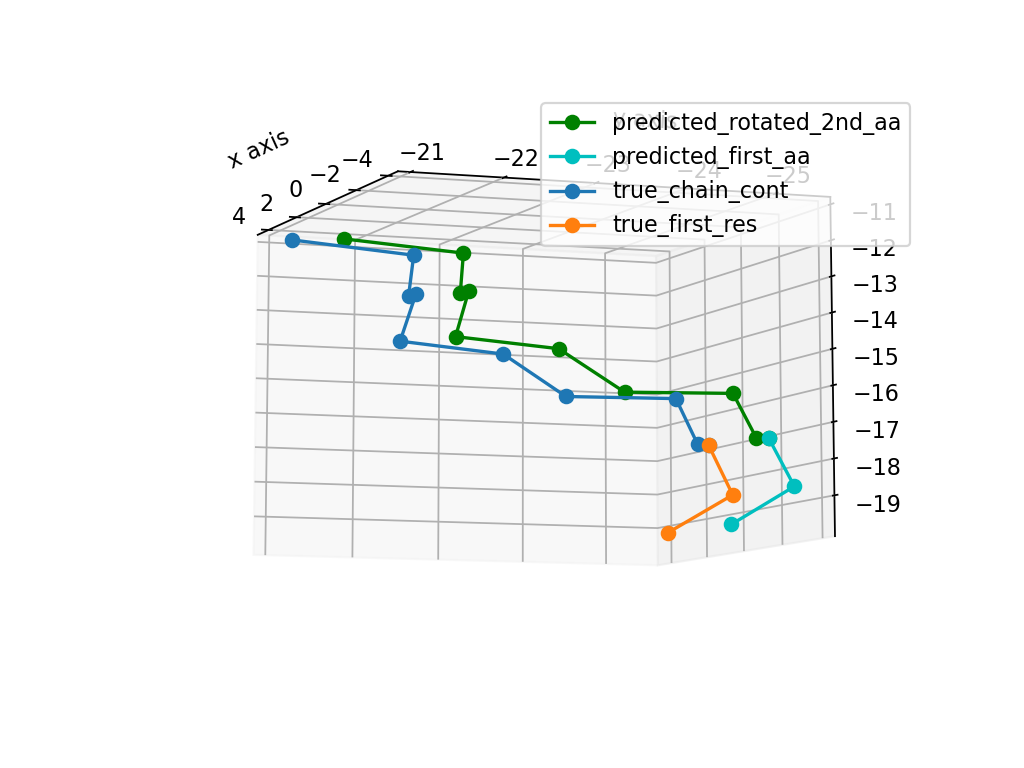

In [27]:
# Set up Figure and 3D Axes 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot using Axes notation and standard function calls
start_res    = torch.cat([labels_aligned[:3, :],
                        labels_aligned[14:14+3],
                        labels_aligned[28:28+3],
                        labels_aligned[42:42+3]], dim=0).numpy()
destin_first = torch.cat([coords_aligned[:3, :],
                        coords_aligned[14:14+3],
                        coords_aligned[28:28+3],
                        coords_aligned[42:42+3]], dim=0).numpy()

ax.plot(destin_first[2:, 0], destin_first[2:, 1], destin_first[2:, 2],  "g-o", label="predicted_rotated_2nd_aa")
ax.plot(destin_first[:3, 0], destin_first[:3, 1], destin_first[:3, 2],  "c-o", label="predicted_first_aa")

ax.plot(start_res[2:, 0], start_res[2:, 1], start_res[2:, 2],  "-o", label="true_chain_cont")
ax.plot(start_res[:3, 0], start_res[:3, 1], start_res[:3, 2],  "-o", label="true_first_res")
# ax.plot(first_res[:, 0], first_res[:, 1], first_res[:, 2],  "r-o", label="second aa")

plt.legend()
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.show()

### Save oriented to manually diagnose

In [28]:
# save predicted
sb = sidechainnet.StructureBuilder(int_seq, crd=coords_aligned) 
sb.to_pdb("preds/predicted_513.pdb")
sb = sidechainnet.StructureBuilder(int_seq, crd=labels_aligned) 
sb.to_pdb("preds/labels_513.pdb")
# go here: https://molstar.org/viewer/
# load chains and use superimposition tool